In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import tensorflow as tf

%config InlineBackend.print_figure_kwargs = {'facecolor':'white'}

## RNN

In [93]:
# Son cada 5 segundos
df = pd.read_csv('datos_2.csv')
# Parece que las primeras 5 filas son ruido
df = df.drop([0,1,2,3,4])
df = df.drop('Unnamed: 0', axis=1)
df.head()

,open,close,high,low,volume,amount,adx,absolute_price_oscillator,balance_of_power,cci,chande_momentum_oscillator,percentage_price_oscillator,macd,wr_6,rsi_6,stochastic_oscillator,tema,tr,atr
5,33703.925355,33704.307758,33715.65,30837.37,90868.023089,2.114485e+06,71.099745,-0.439020,0.000133,-54.695310,-77.831797,-0.001245,-0.888283,0.716238,16.718327,12.465826,33702.493912,2878.28,2879.287127
6,33706.163343,33706.463408,33714.35,30837.37,90868.935971,2.114507e+06,65.126140,-0.414962,0.000104,-44.967921,-60.913044,-0.001200,-0.788629,0.390461,30.033346,24.290732,33704.877808,2876.98,2878.828024
7,33706.944785,33707.360571,33714.35,30837.37,90869.923200,2.114552e+06,61.486611,-0.374021,0.000145,-35.928392,-54.784202,-0.001107,-0.666460,0.287999,35.206969,29.212153,33706.671977,2876.98,2878.501884
8,33706.993852,33707.648716,33714.35,30837.37,90882.382777,2.114706e+06,62.383127,-0.333412,0.000228,-32.045757,-52.913632,-0.001012,-0.557423,0.277988,37.002322,30.792786,33707.655476,2876.98,2878.258834
9,33707.249465,33707.945505,33714.35,30837.37,90886.263839,2.114793e+06,62.978812,-0.293099,0.000242,-28.229419,-51.033636,-0.000913,-0.456678,0.267677,39.088439,32.420834,33708.233730,2876.98,2878.071166


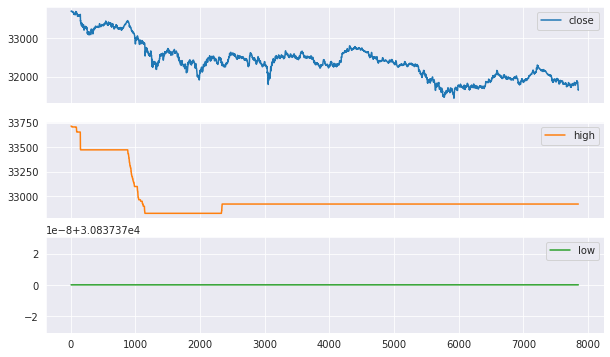

In [4]:
# Esa columna de low no me gusta ...
plot_cols = ['close', 'high', 'low']
plot_features = df[plot_cols]
_ = plot_features.plot(subplots=True, figsize=(10,6))

In [5]:
# La quitaré ya que da problemas
df = df.drop('low', axis=1)

### Split the data

In [6]:
column_indices = {name: i for i, name in enumerate(df.columns)}
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

### Normalize the data

In [7]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

### Windows

In [8]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [9]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

Si nuestros datos están por segundo suena bien hacer batches de 1 minuto.

In [10]:
w = WindowGenerator(input_width=60, label_width=60, shift=1,
                     label_columns=['close'])

example_window = tf.stack([np.array(train_df[:w.total_window_size]),
                           np.array(train_df[100:100+w.total_window_size]),
                           np.array(train_df[200:200+w.total_window_size])])


example_inputs, example_labels = w.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 61, 18)
Inputs shape: (3, 60, 18)
labels shape: (3, 60, 1)


In [11]:
example_labels.shape

TensorShape([3, 60, 1])

384.64686393121036

No me da tiempo de pasar el modelo al streamlit.

In [12]:
w.example = example_inputs, example_labels

def plot(self, model=None, plot_col='close', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue
    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      print('plot_col_index {}'.format(plot_col_index))
      print('label_col_index {}'.format(label_col_index))
      print('inputs {}'.format(inputs.shape))
      print('label_indices {0}'.format(self.label_indices.shape))
      print('predictions {0}'.format(predictions[n, :, label_col_index].shape))
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [s]')

WindowGenerator.plot = plot

In [57]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

In [58]:
df = px.data.stocks()

,date,GOOG,AAPL,AMZN,FB,NFLX,MSFT
0,2018-01-01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,2018-01-08,1.018172,1.011943,1.061881,0.959968,1.053526,1.015988
2,2018-01-15,1.032008,1.019771,1.053240,0.970243,1.049860,1.020524
3,2018-01-22,1.066783,0.980057,1.140676,1.016858,1.307681,1.066561
4,2018-01-29,1.008773,0.917143,1.163374,1.018357,1.273537,1.040708
...,...,...,...,...,...,...,...
100,2019-12-02,1.216280,1.546914,1.425061,1.075997,1.463641,1.720717
101,2019-12-09,1.222821,1.572286,1.432660,1.038855,1.421496,1.752239
102,2019-12-16,1.224418,1.596800,1.453455,1.104094,1.604362,1.784896
103,2019-12-23,1.226504,1.656000,1.521226,1.113728,1.567170,1.802472


In [67]:
predictions[n, :, 0]

<tf.Tensor: shape=(60,), dtype=float32, numpy=
array([ 0.1709024 ,  0.16618511,  0.16109484,  0.17053175,  0.15496123,
        0.11922777,  0.12313526,  0.07203709,  0.0650963 , -0.09970102,
       -0.15065452, -0.159852  , -0.18047431, -0.18150124, -0.18352515,
       -0.20569056, -0.26088372, -0.34727666, -0.5267501 , -0.6016929 ,
       -0.37364525, -0.5942007 , -0.63760227, -0.8859681 , -0.74716735,
       -0.65261465, -0.7017716 , -0.69850796, -0.6344595 , -0.7379806 ,
       -0.74887705, -0.9100389 , -0.9338408 , -0.9417065 , -0.8906098 ,
       -0.8601039 , -0.80860865, -0.7097114 , -0.8548587 , -0.8409699 ,
       -0.80605227, -0.7384184 , -0.73371184, -0.7554304 , -0.73518974,
       -0.7050093 , -0.66375643, -0.6358513 , -0.66739935, -0.6555627 ,
       -0.65096295, -0.54336494, -0.5587463 , -0.6791945 , -0.7746256 ,
       -0.7961736 , -0.74706644, -0.6686381 , -0.66296136, -0.6629917 ],
      dtype=float32)>

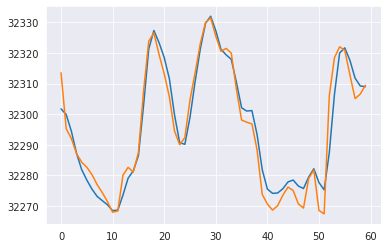

In [91]:
inputs, labels = wide_window.example
plot_col_index = wide_window.column_indices['close']
predictions = lstm_model(inputs)

df_pred = pd.DataFrame()

df_pred['time'] = np.arange(len(inputs[0, :, plot_col_index]))
df_pred['real_1'] = inputs[0, :, plot_col_index]*train_std['close'] + train_mean['close']
df_pred['real_2'] = inputs[1, :, plot_col_index]*train_std['close'] + train_mean['close']
df_pred['real_3'] = inputs[2, :, plot_col_index]*train_std['close'] + train_mean['close']
df_pred['pred_1'] = predictions[0, :, 0]*train_std['close'] + train_mean['close']
df_pred['pred_2'] = predictions[1, :, 0]*train_std['close'] + train_mean['close']
df_pred['pred_3'] = predictions[2, :, 0]*train_std['close'] + train_mean['close']


# for n in range(3):
#     plt.subplot(3, 1, n+1)
#     plt.ylabel('Close [normed]')
#     plt.plot(inputs[n, :, plot_col_index],
#              label='Inputs', marker='.', zorder=-10)
#     plt.plot(predictions[n, :, 0])
    
plt.plot(df_pred['real_3'])
plt.plot(df_pred['pred_3'])

df_pred.to_csv('predictions.csv', index=False)

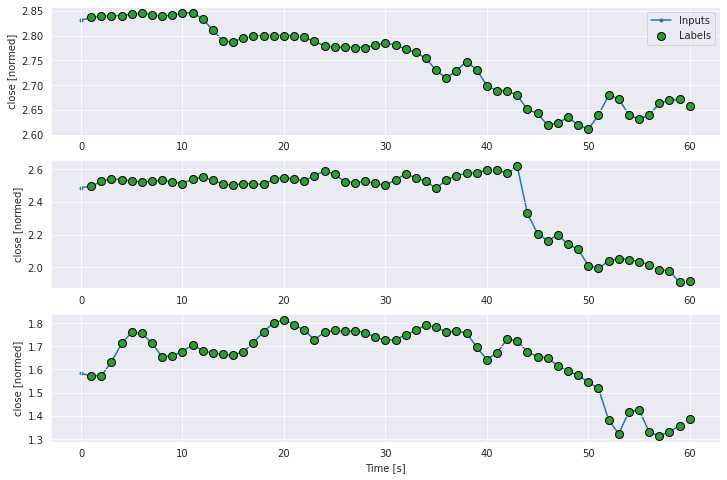

In [13]:
w.plot(plot_col='close')

### Create tf.data.Datasets

In [14]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [15]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [16]:
# Each element is an (inputs, label) pair
w.train.element_spec

(TensorSpec(shape=(None, 60, 18), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 60, 1), dtype=tf.float32, name=None))

In [17]:
for example_inputs, example_labels in w.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 60, 18)
Labels shape (batch, time, features): (32, 60, 1)


## LSTM

In [18]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

Definimos el modelo

In [101]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [102]:
wide_window = WindowGenerator(
    input_width=60, label_width=60, shift=1,
    label_columns=['close'])

# wide_window.plot(baseline)
wide_window

Total window size: 61
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60]
Label column name(s): ['close']

In [103]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 60, 18)
Output shape: (32, 60, 1)


In [104]:
val_performance = {}
performance = {}

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

48/48 [==============================] - 0s 4ms/step - loss: 0.1031 - mean_absolute_error: 0.2886


plot_col_index 1
label_col_index 0
inputs (32, 60, 18)
label_indices (60,)
predictions (60,)
plot_col_index 1
label_col_index 0
inputs (32, 60, 18)
label_indices (60,)
predictions (60,)
plot_col_index 1
label_col_index 0
inputs (32, 60, 18)
label_indices (60,)
predictions (60,)


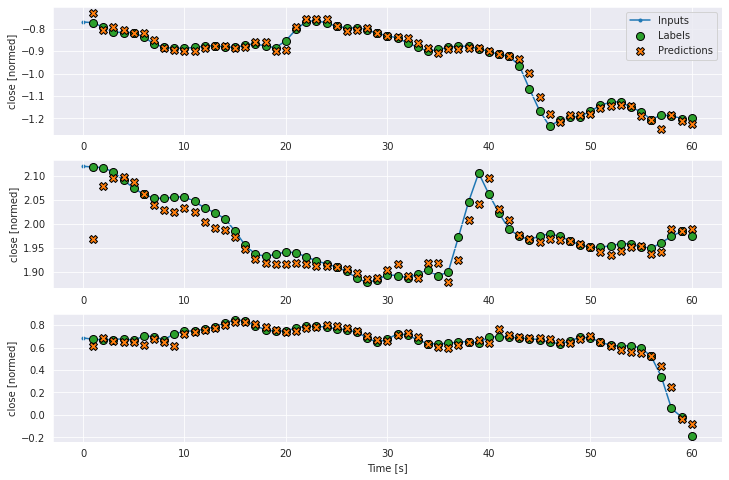

In [105]:
wide_window.plot(lstm_model, plot_col='close')

In [24]:
for x,y in wide_window.make_dataset(val_df).take(1):
    print(x.shape, y.shape)

(32, 60, 18) (32, 60, 1)


In [30]:
lstm_model(x).shape

TensorShape([32, 60, 1])

In [94]:
val_performance.items()

dict_items([('LSTM', [0.1916942000389099, 0.4122745990753174])])

In [31]:
performance.items()

dict_items([('LSTM', [0.1186005026102066, 0.32178017497062683])])